# Conceitos Básicos da Metodologia Gaia

- **Permissões:** Direitos que um agente tem sobre informações ou recursos, como ler (`reads`), modificar (`changes`) ou gerar (`generates`) dados.

- **Protocolos e Atividades:**  
  - *Atividades:* Ações internas realizadas pelo agente sem comunicação externa.  
  - *Protocolos:* Sequências de comunicação entre agentes para realizar tarefas conjuntas.

- **Responsabilidades:** Funções essenciais do agente, divididas em:  
  - *Liveness (Vivacidade):* Garantem que o agente continuará executando suas tarefas principais indefinidamente.  
  - *Safety (Segurança):* Restrições que garantem que o agente não provoque estados indesejados ou falhas no sistema.


---

# Sistema de Rede Inteligente Descentralizada

---

## **Role Schema: HouseholdAgent (HA)**

* **Description**: Representa uma residência individual na rede inteligente. Cada `HouseholdAgent` consome energia de acordo com sua demanda atual e pode também produzir energia através de painéis solares ou outros sistemas renováveis locais (atuando como prosumidor). Ele monitora o uso de energia, os níveis de armazenamento e negocia com o `GridNodeAgent` local para comprar ou vender energia dinamicamente.

* **Protocols and Activities**:  
  - `MonitorConsumption` → Para monitorar o consumo da residência em tempo real.  
  - `MonitorProduction` → Para monitorar a produção de energia local (se houver painéis solares, etc.).  
  - `ManageStorage` → Para controlar a carga e descarga da bateria local.  
  - `RequestEnergy` → Para solicitar energia ao GNA se houver déficit.  
  - `OfferSurplusEnergy` → Para oferecer energia excedente ao GNA quando a produção/armazenamento permite.  
  - `NegotiateEnergyPrice` → Para negociar preço de compra/venda de energia.  
  - `UpdateStatus` → Para enviar relatório de status energético ao GNA.  

* **Permissions**:  
  - reads `consumptionData` → Para monitorar o consumo da residência.  
  - reads `productionData` → Para monitorar a produção de energia local.  
  - reads `storageLevel` → Para saber o nível de energia armazenada na bateria.  
  - reads `priceSignal` → Para receber informações sobre preços de energia.  
  - generates `energyRequest` → Para solicitar energia quando em déficit.  
  - generates `energyOffer` → Para oferecer energia excedente para venda.  
  - generates `statusReport` → Para enviar status energético para o GNA.  

* **Responsibilities**:  
  - **Liveness**: ciclo operacional contínuo, garantindo que o agente monitore e interaja com a rede constantemente:  
    ```
    HouseholdAgent = (EnergyInteraction)ω
    EnergyInteraction = MonitorConsumption; MonitorProduction; ManageStorage; (RequestEnergy | OfferSurplusEnergy); NegotiateEnergyPrice; UpdateStatus
    ```  
  - **Safety**: regras de operação segura e lógica:  
    - `storageLevel = 0 ⇒ OfferSurplusEnergy = nil` → Não pode oferecer energia se não houver carga na bateria.  
    - `consumptionData > productionData + storageLevel ⇒ RequestEnergy = initiate` → Solicita energia se a demanda exceder produção e armazenamento.  
    - `productionData < 0 ⇒ OfferSurplusEnergy = nil` → Não oferece energia se a produção for negativa.  
    - `storageLevel ≥ storageCapacity ⇒ ManageStorage = stop_charging` → Para de carregar quando a bateria estiver cheia.  

---

## **Role Schema: StorageManagerAgent (SMA)**

* **Description**: Representa a gestão de uma bateria local, monitorando SoC/SoH/temperatura e operando carga/descarga com segurança. Negocia energia com o `GridNodeAgent`.

* **Protocols and Activities**:  
  - `MonitorBattery` → Para monitorar parâmetros elétricos da bateria.  
  - `EstimateSoC` → Para estimar o estado de carga atual.  
  - `EstimateSoH` → Para estimar o estado de saúde e degradação da bateria.  
  - `ManageThermal` → Para proteger contra temperaturas fora do intervalo seguro.  
  - `BalanceCells` → Para equilibrar células e prolongar a vida útil da bateria.  
  - `ScheduleCharge` → Para definir quando e quanto carregar.  
  - `ScheduleDischarge` → Para definir quando e quanto descarregar.  
  - `EnforceLimits` → Para impedir operação fora de limites seguros.  
  - `ReportStatus` → Para relatar o status da bateria ao GNA.  
  - `energyRequest` → Para solicitar energia se necessário.  

* **Permissions**:  
  - reads `voltage` → Para monitorar a tensão da bateria.  
  - reads `current` → Para monitorar a corrente da bateria.  
  - reads `temperature` → Para monitorar temperatura e proteger a operação.  
  - reads `stateOfCharge` → Para acompanhar o nível de carga atual.  
  - reads `stateOfHealth` → Para verificar a degradação da bateria.  
  - reads `priceSignal` → Para considerar preços de energia na tomada de decisão.  
  - generates `energyRequest` → Para solicitar energia ao GNA.  
  - generates `chargeCommand` → Para iniciar ou controlar carga.  
  - generates `dischargeCommand` → Para iniciar ou controlar descarga.  
  - generates `statusBattery` → Para enviar relatório do estado da bateria ao GNA.  

* **Responsibilities**:  
  - **Liveness**: ciclo contínuo de monitoramento e controle:  
    ```
    StorageManagerAgent = (BatteryControl)ω
    BatteryControl = MonitorBattery; EstimateSoC; EstimateSoH; ManageThermal; BalanceCells; EnforceLimits; ReportStatus
    ```  
  - **Safety**: regras de operação segura:  
    - `stateOfCharge ≤ SoC_min ⇒ ScheduleDischarge = nil` → Não descarregar abaixo do mínimo seguro.  
    - `stateOfCharge ≥ SoC_max ⇒ ScheduleCharge = nil` → Não carregar acima do máximo seguro.  
    - `temperature ∉ safe_range ⇒ (ScheduleCharge | ScheduleDischarge) = nil` → Bloqueia operação fora da faixa de temperatura segura.  
    - `stateOfHealth < health_threshold ⇒ ReportStatus = alert_degradation` → Relata degradação crítica.  
    - `voltage ∉ [V_min, V_max] ⇒ EnforceLimits = emergency_shutdown` → Desliga em caso de tensão fora do limite.  
    - `fault_detected = true ⇒ (ScheduleCharge | ScheduleDischarge) = nil` → Bloqueia operação em caso de falha.  

---

## **Role Schema: ProducerAgent (PA)**

* **Description**: Representa um produtor de energia renovável na rede, como fazendas solares ou eólicas. Fornece energia para o GNA e ajusta produção conforme a demanda.  

* **Protocols and Activities**:  
  - `MonitorProduction` → Para monitorar a produção atual de energia.  
  - `ForecastOutput` → Para prever produção futura baseada em condições ambientais.  
  - `SendEnergyOffer` → Para enviar oferta de energia ao GNA.  
  - `NegotiateSupply` → Para negociar quantidade e preço de energia.  
  - `AdjustOutput` → Para ajustar produção conforme demanda.  
  - `ReportStatus` → Para relatar status da produção ao GNA.  

* **Permissions**:  
  - reads `weatherData` → Para considerar condições ambientais na produção.  
  - reads `gridDemandSignal` → Para monitorar a demanda local da rede.  
  - reads `productionCapacity` → Para saber a capacidade máxima de produção disponível.  
  - generates `energyOffer` → Para oferecer energia ao GNA.  
  - generates `productionReport` → Para enviar relatório de produção ao GNA.  
  - generates `statusUpdate` → Para informar status da produção.  

* **Responsibilities**:  
  - **Liveness**: ciclo contínuo de produção e comunicação:  
    ```
    ProducerAgent = (EnergyProduction)ω
    EnergyProduction = MonitorProduction; ForecastOutput; SendEnergyOffer; NegotiateSupply; AdjustOutput; ReportStatus
    ```  
  - **Safety**: garante operação segura e eficiente:  
    - `productionCapacity = 0 ⇒ energyOffer = nil` → Não oferece energia sem capacidade.  
    - `weatherData = poor ⇒ ForecastOutput = decrease` → Reduz previsão de produção em condições climáticas ruins.  
    - `gridDemandSignal = low ⇒ AdjustOutput = reduce` → Reduz produção se demanda da rede for baixa.  
    - `gridDemandSignal = high ⇒ AdjustOutput = maximize` → Maximiza produção se demanda for alta.  

---

## **Role Schema: GridNodeAgent (GNA)**

* **Description**: Atua como hub local, equilibrando oferta e demanda na região. Agrega dados de HAs, SMAs e PAs e coordena com GNAs vizinhos para redistribuição de energia, garantindo estabilidade da rede.

* **Protocols and Activities**:  
  - `ReceiveEnergyData` → Para receber dados de consumo, produção e armazenamento dos agentes locais.  
  - `EvaluateLocalBalance` → Para avaliar o balanço local de energia.  
  - `CoordinateWithNeighbors` → Para redistribuir energia com GNAs vizinhos.  
  - `ManageStorage` → Para gerenciar armazenamento local e otimizar uso da energia.  
  - `NegotiateTransfers` → Para negociar envio/recebimento de energia entre nós vizinhos.  
  - `DistributeEnergy` → Para distribuir energia entre os HAs conectados.  
  - `ReportGridStatus` → Para relatar status da rede e balanço energético.  

* **Permissions**:  
  - reads `energyRequests` → Para conhecer solicitações de energia dos HAs.  
  - reads `energyOffers` → Para conhecer ofertas de energia dos PAs e HAs.  
  - reads `localStorageLevel` → Para monitorar nível de energia armazenada localmente.  
  - reads `neighborStatus` → Para receber informações de estabilidade dos GNAs vizinhos.  
  - generates `transferRequest` → Para solicitar energia a nós vizinhos.  
  - generates `distributionPlan` → Para criar plano de distribuição de energia local.  
  - generates `gridStatusReport` → Para relatar o status do nó.  
  - generates `offersTime` → Para indicar prazo de resposta às ofertas.  

* **Responsibilities**:  
  - **Liveness**: ciclo contínuo de controle e distribuição:  
    ```
    GridNodeAgent = (GridManagement)ω
    GridManagement = ReceiveEnergyData; EvaluateLocalBalance; (CoordinateWithNeighbors | NegotiateTransfers); ManageStorage; DistributeEnergy; ReportGridStatus
    ```  
  - **Safety**: garante operação segura da rede:  
    - `localStorageLevel = full ⇒ ReceiveEnergyData = pause` → Pausa recebimento se armazenamento local estiver cheio.  
    - `totalLocalDemand > totalLocalSupply ⇒ CoordinateWithNeighbors = initiate` → Redistribui energia com vizinhos se demanda exceder oferta.  
    - `neighborStatus = unstable ⇒ NegotiateTransfers = defer` → Adia negociações com nós vizinhos instáveis.  
    - `totalOffers < totalRequests ⇒ transferRequest = initiate` → Solicita transferência se ofertas forem insuficientes.  

---

#### EXEMPLO DE PEDIDO DE ENERGIA

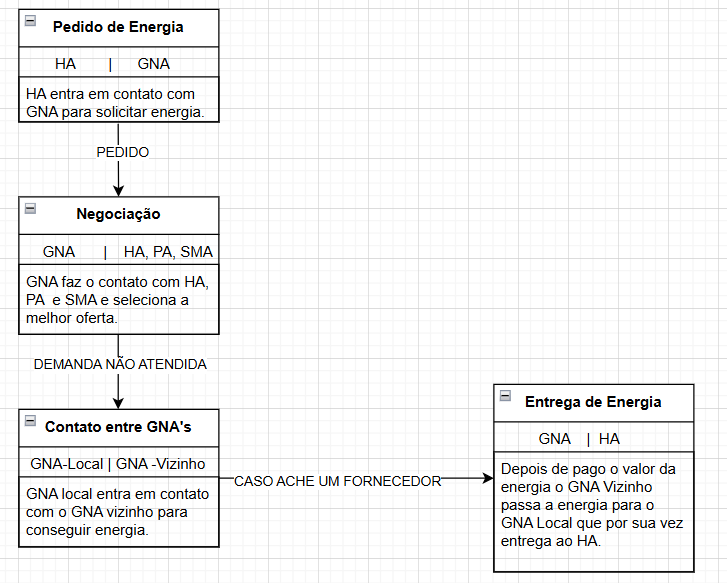